# Environment

Now we have a trainable discriminator - it's time to build the environment

In [1]:
## Imports and data loading

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import metrics

from musicrl.midi2vec import MidiVectorMapper
from musicrl.render import *
from musicrl.data import RandomMidiDataGenerator

import pretty_midi
from glob import glob


REAL = 1
GEN = 0

In [2]:
ls maestro-v2.0.0

2004/                2013/                LICENSE
2006/                2014/                README
2008/                2015/                maestro-v2.0.0.csv
2009/                2017/                maestro-v2.0.0.json
2011/                2018/


In [3]:
filepaths = list(glob('maestro-v2.0.0/2008/**.midi'))
real_midis = [pretty_midi.PrettyMIDI(i) for i in filepaths]
mapper = MidiVectorMapper(real_midis)

In [4]:
mapper = MidiVectorMapper(real_midis)
real_seq = mapper.midi2vec(real_midis[1])
real_seq.shape

(60867, 5)

In [23]:
import gym
import pretty_midi


class SeqEnvironment(gym.Env):
    """We ignore control change events for now
    """
    def __init__(
        self,
        discriminator,
        mapper,
        observation_shape=(128,),
        change_rate=0.01
    ):
        super().__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        # self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Example for using image as input:
        # self.observation_space = spaces.Box(low=0, high=255,
        #                                    shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        self.discriminator = discriminator
        self.mapper = mapper
        self.observation_shape = observation_shape
        self.change_rate = change_rate
        self.reset()
        
    def step(self, action):
        self.current_seq.append(action)
        self.observation  = self.observation + np.random.normal(0, self.change_rate, size=self.observation_shape)
        reward, done, info = None, None, None
        return np.array(self.observation), reward, done, info

    def reset(self):
        self.current_seq = []
        self.observation = np.random.normal(0, 1, size=self.observation_shape)
        return self.observation  # reward, done, info can't be included

    def render(self, mode='human'):
        pass
    
    def close (self):
        pass

In [ ]:
mapper.column_meaning

In [7]:
env = SeqEnvironment(None, mapper)

for action in real_seq:
    env.step(action)

wav = mapper.vec2midi(env.current_seq).synthesize(22050)
display(Audio(wav, rate=22050))


# Plot a 2d subspace of the observations

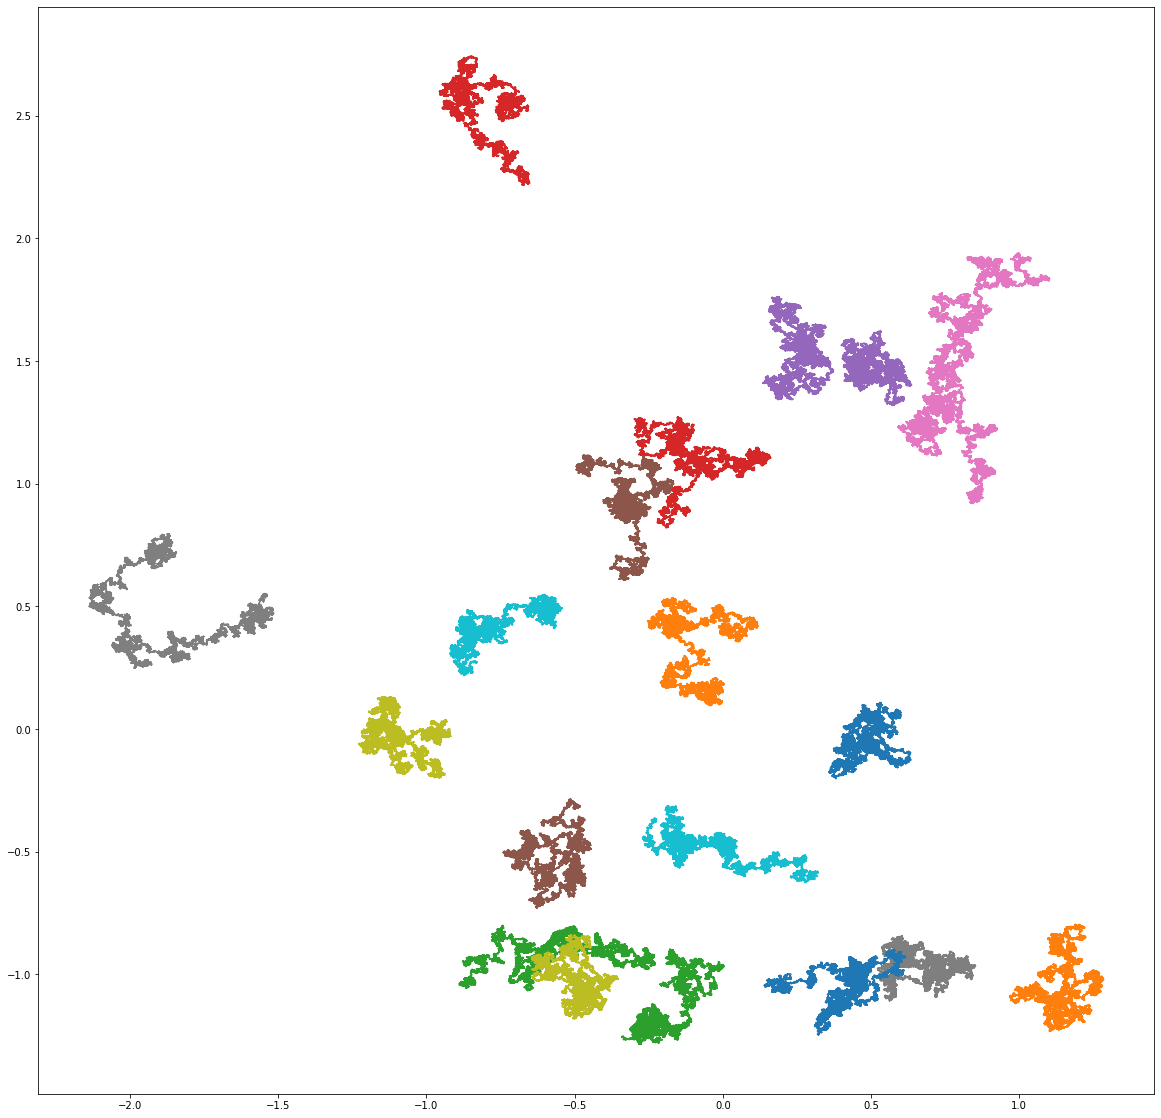

In [40]:
env = SeqEnvironment(None, mapper, observation_shape=(2,), change_rate=1e-3)

plt.figure(figsize=(20, 20))

for _ in range(20):
    observations = []
    for action in real_seq:
        o, _, _, _ = env.step(action)
        observations.append(o)
    x = np.array(observations)[:,0]
    y = np.array(observations)[:,1]
    plt.plot(x, y)
    env.reset()
plt.show()